In [1]:
# Load modules
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# List data files in data directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# load and preview
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()
train_data.shape

(891, 12)

In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()
test_data.shape

(418, 11)

In [4]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [7]:
# Combine Train and Test data sets for analysis and wrangling
full_data = pd.concat([train_data, test_data], axis=0).reset_index(drop = True)

full_data.info()
full_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [8]:
train_data.info()
print('_'*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [9]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [11]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [12]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [13]:
train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [14]:
train_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [15]:
train_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


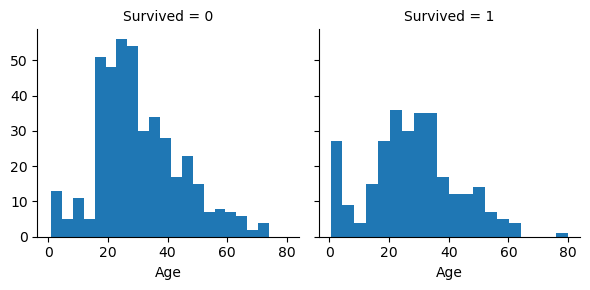

In [16]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

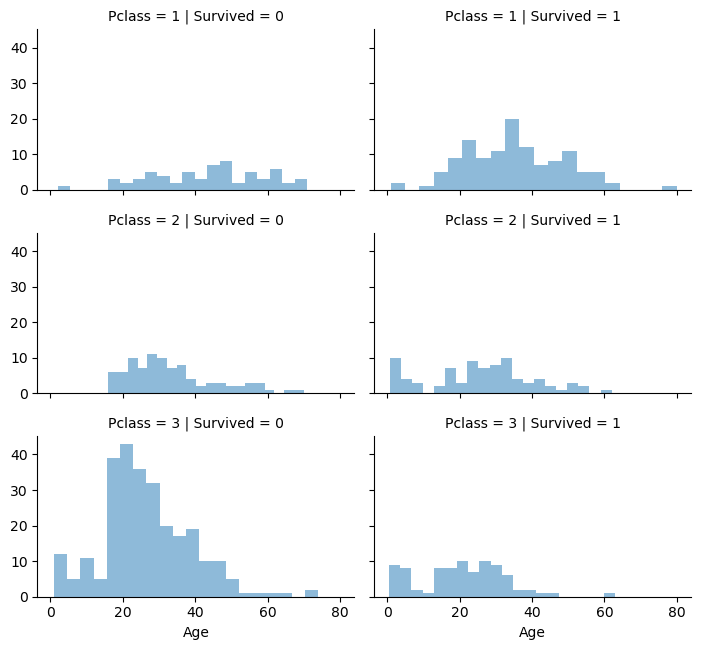

In [17]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.7/site-packages/s

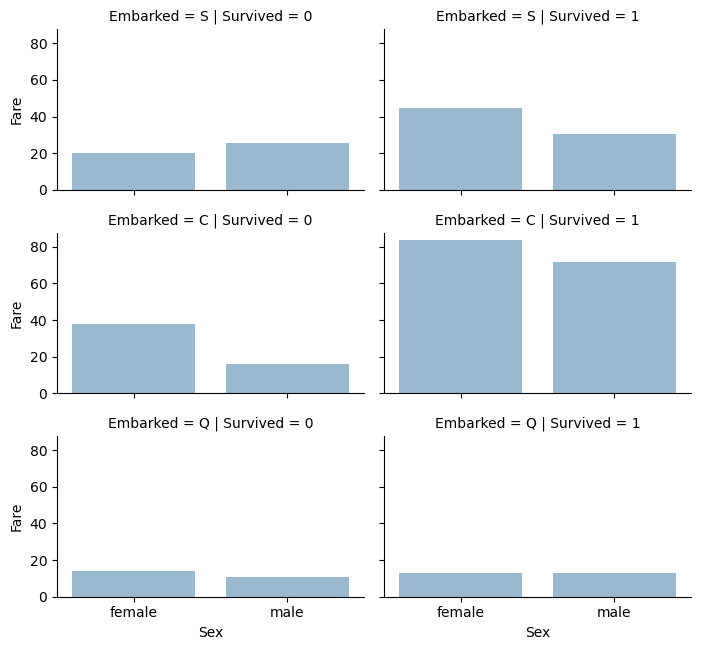

In [18]:
grid = sns.FacetGrid(train_data, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

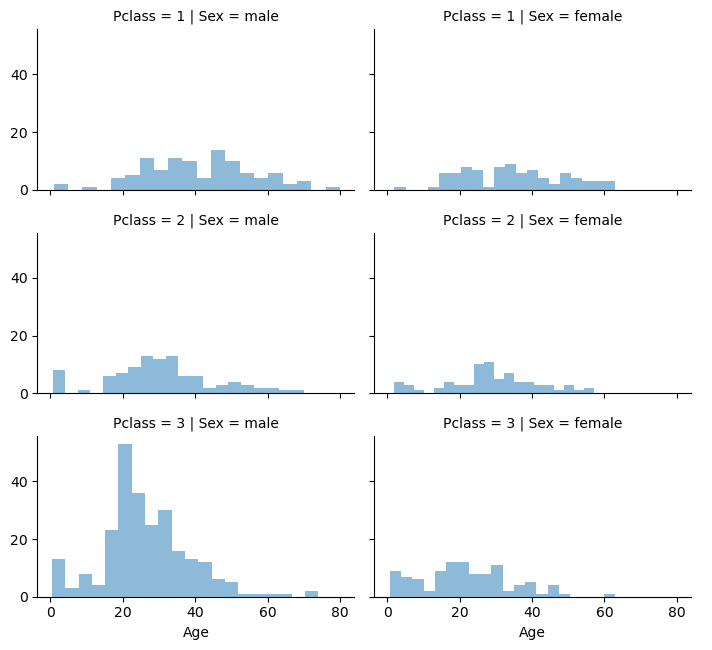

In [19]:
grid = sns.FacetGrid(train_data, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

<AxesSubplot:ylabel='Density'>

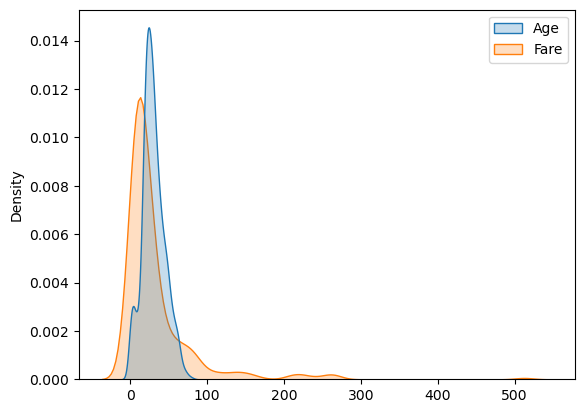

In [20]:
# Plot Fare and Age
features = ["Age", "Fare"]
sns.kdeplot(full_data[features], fill=True)

In [21]:
# Sex and Embarkation
need_dummies = ["Sex", "Embarked"]
dummies = pd.get_dummies(full_data[need_dummies])

full_data = pd.concat([full_data, dummies], axis = 1)

# PClass
pclass = full_data["Pclass"]
pclass = np.array(pclass.tolist()).reshape(len(pclass),1)

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(pclass)

full_data["Pclass1"] = onehot_encoded[:,0]
full_data["Pclass2"] = onehot_encoded[:,1]
full_data["Pclass3"] = onehot_encoded[:,2]

full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass1,Pclass2,Pclass3
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1,0.0,0.0,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0,1.0,0.0,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1,0.0,0.0,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,0,1,1.0,0.0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,1,0.0,0.0,1.0


In [22]:
# Raw Correlations of numerical features
full_data.corr()['Survived'].sort_values(ascending=False)

Survived       1.000000
Sex_female     0.543351
Pclass1        0.285904
Fare           0.257307
Embarked_C     0.168240
Pclass2        0.093349
Parch          0.081629
Embarked_Q     0.003650
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Embarked_S    -0.155660
Pclass3       -0.322308
Pclass        -0.338481
Sex_male      -0.543351
Name: Survived, dtype: float64

In [23]:
# Overall Probability of Survival (Train Set data available only)
survival_rate = sum(train_data["Survived"]) / len(train_data["Survived"])
survival_rate

0.3838383838383838

In [24]:
# Adj_Fare
persons_per_ticket = full_data["Name"].groupby(full_data["Ticket"]).count()

for i in range(0,len(full_data)):
    full_data.loc[i, "Adj_Fare"] = full_data.loc[i, "Fare"] / persons_per_ticket.loc[full_data.loc[i, "Ticket"]]

In [25]:
### Deck
# get deck from Cabin numbers where provided
full_data["Deck"] = full_data["Cabin"].str[0]
print(full_data.Deck.value_counts()) 
full_data.loc[full_data['Deck'] == "T", 'Deck'] = None  # no Deck T on Titanic - assume error to be removed

# convert deck letter to score
deck_values = {"A":6, "B":5, "C":4,"D":3,"E":2,"F":1,"G":0}
full_data["Deck_Score"] = full_data["Deck"].replace(deck_values)

# add Deck_Score's for those travelling on same ticket as another passenger with a Deck_Score
deck_by_ticket = full_data["Deck_Score"].groupby(full_data["Ticket"]).max()

for i in range(0,len(full_data)):
    if pd.isnull(full_data["Deck"][i]):
        full_data.loc[i, "Deck_Score"] = deck_by_ticket.loc[full_data.loc[i, "Ticket"]]

print(
    full_data.Deck.isna().sum(),
    full_data.Deck_Score.isna().sum()
)

# add Deck_Score = 0 for those passengers without a deck
full_data["Deck_Score"] = full_data["Deck_Score"].fillna(value = 0)

full_data.Deck_Score.isna().sum()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Deck, dtype: int64
1015 999


0

In [26]:
# Probability by Age Group
bins = np.arange(0,85,5)

age_groups = train_data["Survived"].groupby(pd.cut(train_data["Age"], bins = bins)).count()
survivors_by_age = train_data["Survived"].groupby(pd.cut(train_data["Age"], bins = bins)).sum()
ttl_passengers_with_age = sum(age_groups)
ttl_survivors_with_age = sum(survivors_by_age)

age_analysis = pd.DataFrame(list(zip(
    age_groups.index,
    round(age_groups / ttl_survivors_with_age,2),
    round(survivors_by_age / age_groups,2))),
    columns = ["Age_Bracket", "Percent_on_Ship", "Survival_Rate"])

age_analysis["Excess_Survival_Rate"] = round(age_analysis["Survival_Rate"] - survival_rate, 2)

age_analysis



,Age_Bracket,Percent_on_Ship,Survival_Rate,Excess_Survival_Rate
0,"(0, 5]",0.15,0.70,0.32
1,"(5, 10]",0.07,0.35,-0.03
2,"(10, 15]",0.07,0.58,0.20
3,"(15, 20]",0.33,0.34,-0.04
4,"(20, 25]",0.42,0.34,-0.04
5,"(25, 30]",0.37,0.39,0.01
6,"(30, 35]",0.30,0.47,0.09
7,"(35, 40]",0.23,0.42,0.04
8,"(40, 45]",0.16,0.36,-0.02
9,"(45, 50]",0.13,0.41,0.03


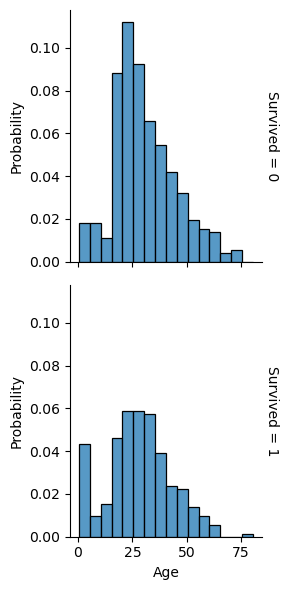

In [27]:
sns.displot(
    train_data, x="Age", row="Survived",
    binwidth=5, height=3, stat='probability', facet_kws=dict(margin_titles=True),
)

In [28]:
# One Hot Encoding for Age brackets
full_data["5_and_under"] = (full_data["Age"] <= 5) * 1
full_data["5 to 15"] = (full_data["Age"] > 5 * 1) * (full_data["Age"] <= 15 * 1) * 1
full_data["over15"] = (full_data["Age"] > 15) * 1
full_data["noAge"] = full_data["Age"].isna() * 1

full_data.head(25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass1,Pclass2,Pclass3,Adj_Fare,Deck,Deck_Score,5_and_under,5 to 15,over15,noAge
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0.0,0.0,1.0,7.250000,NaN,0.0,0,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1.0,0.0,0.0,35.641650,C,4.0,0,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0.0,0.0,1.0,7.925000,NaN,0.0,0,0,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1.0,0.0,0.0,26.550000,C,4.0,0,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0.0,0.0,1.0,8.050000,NaN,0.0,0,0,1,0
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,...,0.0,0.0,1.0,8.458300,NaN,0.0,0,0,0,1
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,1.0,0.0,0.0,25.931250,E,2.0,0,0,1,0
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,...,0.0,0.0,1.0,4.215000,NaN,0.0,1,0,0,0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,0.0,0.0,1.0,3.711100,NaN,0.0,0,0,1,0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,...,0.0,1.0,0.0,15.035400,NaN,0.0,0,1,0,0


In [29]:
# Fare
mu = full_data["Fare"].mean()
sd = full_data["Fare"].std()

full_data["Fare"] = (full_data["Fare"] - mu)/sd
full_data["Fare"] = full_data["Fare"].fillna(value = 0)


# Adj_Fare
mu = full_data["Adj_Fare"].mean()
sd = full_data["Adj_Fare"].std()

full_data["Adj_Fare"] = (full_data["Adj_Fare"] - mu)/sd
full_data["Adj_Fare"] = full_data["Adj_Fare"].fillna(value = 0)


# Age
mu = full_data["Age"].mean()
sd = full_data["Age"].std()

full_data["Age"] = (full_data["Age"] - mu)/sd
full_data["Age"] = full_data["Age"].fillna(value = 0)

full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Sex_female   1309 non-null   uint8  
 13  Sex_male     1309 non-null   uint8  
 14  Embarked_C   1309 non-null   uint8  
 15  Embarked_Q   1309 non-null   uint8  
 16  Embarked_S   1309 non-null   uint8  
 17  Pclass1      1309 non-null   float64
 18  Pclass2      1309 non-null   float64
 19  Pclass

In [30]:
# Split Full Data back into train and test set
train_data = full_data.iloc[:len(train_data), :]
test_data = full_data.iloc[len(train_data):, :].reset_index(drop = True)
train_data.shape
train_data.head()

# Split train data into train and dev set
train80, dev20 = train_test_split(train_data, test_size = 0.2, random_state = 42)

# Split out Y's
y_train80 = train80["Survived"]
y_dev20 = dev20["Survived"]
y_test = test_data["Survived"]

# # Select features (X1, X2 .... Xn)
features = [
    "Pclass1",
    "Pclass2",
    "Pclass3",
    "Sex_female",
    "Sex_male",
    "Parch",
    "SibSp",
    "Age",
    "5_and_under",
    "5 to 15",
    "over15",
    "noAge",
    "Fare",
    "Adj_Fare",
    "Embarked_C",
    "Embarked_Q",
    "Embarked_S",
    "Deck_Score"
]

# Split out X's and Convert categorical data to numbers. 
X_train80 = train80[features]
X_dev20 = dev20[features]
X_test = test_data[features]

X_train80.tail()

,Pclass1,Pclass2,Pclass3,Sex_female,Sex_male,Parch,SibSp,Age,5_and_under,5 to 15,over15,noAge,Fare,Adj_Fare,Embarked_C,Embarked_Q,Embarked_S,Deck_Score
106,0.0,0.0,1.0,1,0,0,0,-0.616168,0,0,1,0,-0.495482,-0.524330,0,0,1,0.0
270,1.0,0.0,0.0,0,1,0,0,0.000000,0,0,0,1,-0.044350,0.054765,0,0,1,0.0
860,0.0,0.0,1.0,0,1,0,2,0.771420,0,0,1,0,-0.370705,-0.568286,0,0,1,0.0
435,1.0,0.0,0.0,1,0,2,1,-1.101824,0,1,0,0,1.675169,1.124430,0,0,1,5.0
102,1.0,0.0,0.0,0,1,1,0,-0.616168,0,0,1,0,0.849945,1.762080,0,0,1,3.0


In [31]:
# Basic model to begin
params = {'loss_function':'Logloss', #objective
         'eval_metric':'AUC', #Area Under Curve metric
         'verbose': 200, # output info during training every x number of iterations
         'random_seed': 42
         }

cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X_train80, y_train80, # training data
          eval_set = (X_dev20, y_dev20),  # dev set
          use_best_model = True, # True if we don't want to save trees
          plot = True # Shows visuals of the training process.
         );


          

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.029139
0:	test: 0.8719434	best: 0.8719434 (0)	total: 57.1ms	remaining: 57s
200:	test: 0.8875161	best: 0.8962033 (37)	total: 361ms	remaining: 1.43s
400:	test: 0.8971686	best: 0.8990991 (341)	total: 679ms	remaining: 1.01s
600:	test: 0.8898327	best: 0.8990991 (341)	total: 1.03s	remaining: 682ms
800:	test: 0.8853282	best: 0.8990991 (341)	total: 1.37s	remaining: 341ms
999:	test: 0.8819820	best: 0.8990991 (341)	total: 1.71s	remaining: 0us

bestTest = 0.8990990991
bestIteration = 341

Shrink model to first 342 iterations.


In [32]:
# Feature importance according to CatBoost Model
cbc_1.get_feature_importance()

feat_import = [t for t in zip(features, cbc_1.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns = ['Feature','VarImp'])
feat_import_df = feat_import_df.sort_values('VarImp', ascending = False)

feat_import_df

,Feature,VarImp
3,Sex_female,16.782851
4,Sex_male,15.215127
7,Age,13.560141
13,Adj_Fare,12.887261
12,Fare,10.734690
17,Deck_Score,6.482634
6,SibSp,5.271724
2,Pclass3,4.492687
1,Pclass2,3.139302
5,Parch,2.630111


In [33]:
# Recombine Train and Dev Sets
y_train = pd.concat([y_train80, y_dev20])
X_train = pd.concat([X_train80, X_dev20])

In [34]:
params = {'depth': 5,
          'verbose': 200, 
          'learning_rate': 0.01,
          'iterations': 2000
         }

cbc_Final = CatBoostClassifier(**params)
cbc_Final.fit(X_train, y_train, # training data
          plot = True # Shows visuals of the training process.
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6864428	total: 1.67ms	remaining: 3.34s
200:	learn: 0.3850863	total: 255ms	remaining: 2.28s
400:	learn: 0.3481007	total: 524ms	remaining: 2.09s
600:	learn: 0.3235548	total: 791ms	remaining: 1.84s
800:	learn: 0.3023754	total: 1.06s	remaining: 1.59s
1000:	learn: 0.2823291	total: 1.33s	remaining: 1.33s
1200:	learn: 0.2633476	total: 1.6s	remaining: 1.07s
1400:	learn: 0.2454213	total: 1.84s	remaining: 787ms
1600:	learn: 0.2320902	total: 2.06s	remaining: 515ms
1800:	learn: 0.2186851	total: 2.33s	remaining: 258ms
1999:	learn: 0.2059499	total: 2.6s	remaining: 0us


In [35]:
# Feature importance according to CatBoost Model
cbc_Final.get_feature_importance()

feat_import = [t for t in zip(features, cbc_Final.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns = ['Feature','VarImp'])
feat_import_df = feat_import_df.sort_values('VarImp', ascending = False)

feat_import_df

,Feature,VarImp
7,Age,16.231604
13,Adj_Fare,15.996191
12,Fare,14.525229
4,Sex_male,13.185712
3,Sex_female,12.946787
17,Deck_Score,5.288941
6,SibSp,4.698101
2,Pclass3,3.891751
1,Pclass2,2.065864
5,Parch,1.993510


In [36]:
# CatBoost predictions
predictions = cbc_Final.predict(X_test)
predictions = predictions.astype(int) 
predictions.dtype

dtype('int64')

In [37]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 26), (891,), (418, 26))

In [38]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission12.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
